In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

In [2]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D))
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [21]:
print(X_train.shape, y_train.shape)
print(w_true)

(40, 10) (40,)
[ 0.24835708 -0.06913215  0.32384427  0.76151493 -0.11707669 -0.11706848
  0.78960641  0.38371736 -0.23473719  0.27128002]


In [3]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [4]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [5]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 66.347


In [6]:
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

In [7]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0532537
Mean absolute error on test data:
0.169293


In [8]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

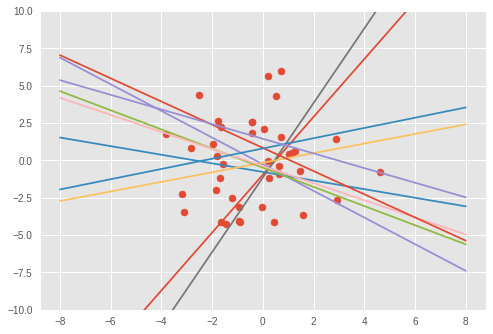

In [9]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b, n_samples=10)

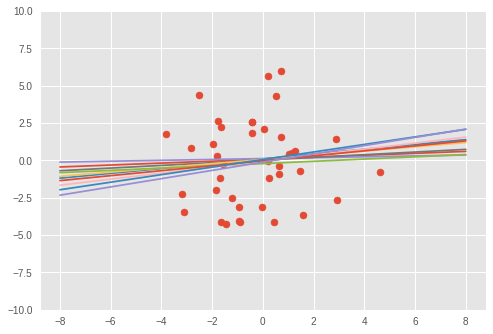

In [11]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb, n_samples=10)